In [1]:
from pyomo.environ import *
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import time

In [2]:
N= 25
df=pd.DataFrame()
df['x']= [random.random() for i in range(N)]
df['y']= [random.random() for i in range(N)]
df['c']= [random.randint(0,1) for i in range(N)]
df

,x,y,c
0,0.562539,0.456148,1
1,0.305930,0.990781,1
2,0.480551,0.974520,1
3,0.519639,0.173766,1
4,0.528628,0.769045,1
5,0.243803,0.832328,1
6,0.379342,0.371002,0
7,0.360388,0.157756,0
8,0.793967,0.582600,0
9,0.915850,0.602913,0


In [3]:
model = AbstractModel()
model.i = RangeSet(N)
model.x = Var(model.i, within=Binary)
model.R = Var(bounds=(0,0.5), within=Reals)
model.Count = Var(bounds=(1,N), within=Reals)

x0, y0 = 0.5, 0.5 

def D_rule(model, i):
    return np.sqrt( (df.loc[i-1,'x']-x0)**2 + (df.loc[i-1,'y']-y0)**2 )
model.D = Param(model.i, rule=D_rule)

def C1_rule(model, i):
    return model.D[i] <= model.R + 2*(1-model.x[i])-0.01
model.C1 = Constraint(model.i, rule=C1_rule)

def C1A_rule(model, i):
    return model.D[i] >= 0.01+ model.R - 2*(model.x[i])
model.C1A = Constraint(model.i, rule=C1A_rule)



def C2_rule(model):
    return sum(model.x[i]*(1-df.loc[i-1,'c']) for i in model.i ) == model.Count
model.C2 = Constraint( rule=C2_rule)

def C3_rule(model):
    return sum(model.x[i]*(df.loc[i-1,'c'])  for i in model.i) == model.Count
model.C3 = Constraint( rule=C3_rule)

def obj_rule(model):
    return model.R
model.OF = Objective(rule=obj_rule,sense=maximize)

In [4]:
opt = SolverFactory('glpk')
instance = model.create_instance()

start = time.time()
results = opt.solve(instance) # solves and updates instance
print('Time is ', round(time.time() - start, 4) ) 

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)
print(value(instance.OF) , value(instance.Count))

Time is  0.0494
feasible
0.464918075924774 9.0


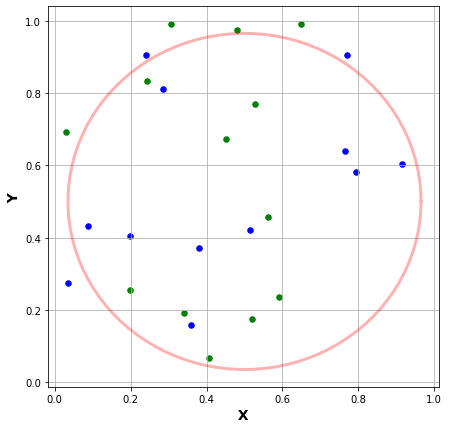

In [7]:
A=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(7,7))
x0, y0 = 0.5, 0.5 

r= value(instance.R)
theta = np.linspace(0,2*np.pi,100)
X= x0+r*np.cos(theta)
Y= y0+r*np.sin(theta)

plt.plot(X,Y,c='r', lw=3, alpha = 0.3)

for i in instance.i:
    x0 = df.loc[i-1,'x']
    y0 = df.loc[i-1,'y']
    if df.loc[i-1,'c'] == 0 :
        KOLOR= 'b'
    else:
        KOLOR= 'g'
    plt.scatter(x0,y0, s=30 , c=KOLOR )

plt.xlabel('  X  ' , fontweight = 'bold', fontsize= 14)
plt.ylabel('  Y  ', fontweight = 'bold', fontsize= 14)
plt.grid()
plt.show()

In [8]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.464918075924774
  Upper bound: 0.464918075924774
  Number of objectives: 1
  Number of constraints: 53
  Number of variables: 28
  Number of nonzeros: 128
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 19
      Number of created subproblems: 19
  Error rc: 0
  Time: 0.022581815719604492
# ----------------------------------------------------------
#   Solution Information
# ------